# Traffic Light Detection

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from time import time
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.preprocessing.image import array_to_img, img_to_array
from keras import backend as K

%matplotlib inline

Using TensorFlow backend.


## CNN

In [2]:
img_width, img_height = 150, 150

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4))
model.add(Activation('softmax'))

In [3]:
K.image_data_format()

'channels_last'

### Train Model

In [4]:
batch_size = 16
epochs = 50

In [6]:
train_datagen = ImageDataGenerator(
    data_format='channels_last',
    rescale=1./255,
    rotation_range=10,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [7]:
train_generator = train_datagen.flow_from_directory(
    directory='data/train',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 5257 images belonging to 4 classes.


In [8]:
nb_class = train_generator.num_class
classes = train_generator.class_indices
nb_train_samples = train_generator.samples

In [9]:
nb_train_samples

5257

In [5]:
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [11]:
%%time

model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs)

Epoch 1/50
328/328 [==============================] - 128s - loss: 0.9346 - acc: 0.6105   
Epoch 2/50
328/328 [==============================] - 90s - loss: 0.6333 - acc: 0.7341    
Epoch 3/50
328/328 [==============================] - 90s - loss: 0.5628 - acc: 0.7577    
Epoch 4/50
328/328 [==============================] - 90s - loss: 0.5120 - acc: 0.7693    
Epoch 5/50
328/328 [==============================] - 90s - loss: 0.4718 - acc: 0.7923    
Epoch 6/50
328/328 [==============================] - 90s - loss: 0.4317 - acc: 0.8068    
Epoch 7/50
328/328 [==============================] - 90s - loss: 0.4153 - acc: 0.8156    
Epoch 8/50
328/328 [==============================] - 90s - loss: 0.3844 - acc: 0.8179    
Epoch 9/50
328/328 [==============================] - 90s - loss: 0.3661 - acc: 0.8374    
Epoch 10/50
328/328 [==============================] - 90s - loss: 0.3525 - acc: 0.8426    
Epoch 11/50
328/328 [==============================] - 90s - loss: 0.3336 - acc: 0.8490  

### Save Model

In [10]:
model_name = 'model_%d_%d_%d' % (batch_size, epochs, int(time() * 1e6))
model_name

'model_16_50_1506899045127710'

In [11]:
model.save_weights(model_name + '.h5') 

In [12]:
model_json = model.to_json()

In [13]:
with open(model_name + '.json', "w") as json_file:
    json_file.write(model_json)

### Test Model

In [14]:
test_datagen = ImageDataGenerator(
    data_format='channels_last',
    rescale=1./255)

test_generator = train_datagen.flow_from_directory(
    'data/loop_with_traffic_light/training',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 1151 images belonging to 4 classes.


In [15]:
%%time

i = 0
for images in test_generator:
    print(images[0].shape)
    predictions = model.predict(images[0])
    i += 1
    if i > 0:
        break

(16, 150, 150, 3)
CPU times: user 456 ms, sys: 20 ms, total: 476 ms
Wall time: 475 ms


### Visualize Examples

In [16]:
class_to_idx = train_generator.class_indices
class_to_idx

{'green': 0, 'red': 1, 'unknown': 2, 'yellow': 3}

#### Overlay Color Labels

In [17]:
red = Image.new('RGB', (img_width, 10), (255, 0, 0))
green = Image.new('RGB', (img_width, 10), (0, 255, 0))
yellow = Image.new('RGB', (img_width, 10), (244, 219, 36))
unknown = Image.new('RGB', (img_width, 10), (0, 0, 0))

In [18]:
idx_to_class = {}
idx_to_overlay = {}

In [20]:
for k, v in class_to_idx.items():
    idx_to_class[v] = k
    idx_to_overlay[v] = eval(k)

In [21]:
idx_to_class

{0: 'green', 1: 'red', 2: 'unknown', 3: 'yellow'}

In [22]:
idx_to_overlay

{0: <PIL.Image.Image image mode=RGB size=150x10 at 0x7FD2351FC0D0>,
 1: <PIL.Image.Image image mode=RGB size=150x10 at 0x7FD217B18B90>,
 2: <PIL.Image.Image image mode=RGB size=150x10 at 0x7FD217B323D0>,
 3: <PIL.Image.Image image mode=RGB size=150x10 at 0x7FD217B32390>}

#### Sample Images from Several Sources

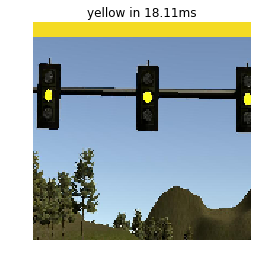

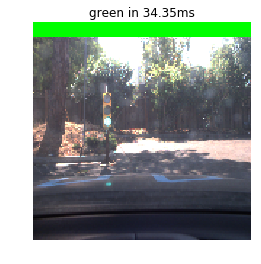

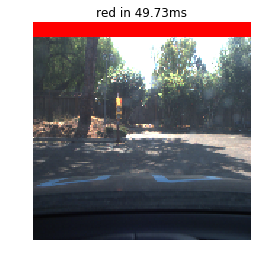

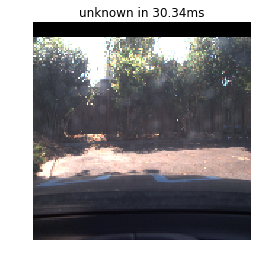

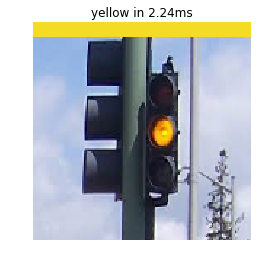

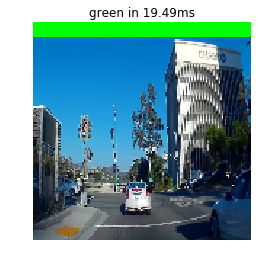

CPU times: user 760 ms, sys: 792 ms, total: 1.55 s
Wall time: 661 ms


In [23]:
%%time

images = [
    load_img('data/simulator_traffic_light/training/yellow/sim-1506291430325470.jpeg'),
    load_img('data/loop_with_traffic_light/training/green/1503524655778037037.png'),
    load_img('data/just_traffic_light/training/red/1503524771576164202.png'),
    load_img('data/just_traffic_light/training/unknown/1503524776309465909.png'),
    load_img('data/internet/yellow/yellow-internet-0013.jpg'),
    load_img('data/dashcam/green/2017_0929_172227_530-000051.jpg'),
]

for image in images:
    
    # Pipeline start time
    start = time()
    
    # Resize to 150x150
    img = image.resize((img_width, img_height))

    # Normalized numpy array with shape (150, 150, 3)
    x = img_to_array(img, data_format='channels_last') / 255.

    # Numpy array with shape (1, 150, 150, 3)
    x = x.reshape((1,) + x.shape)
    
    prediction = model.predict(x)
    
    pred_idx = np.argmax(prediction[0])
    img.paste(idx_to_overlay[pred_idx])
    
    # Pipeline end prediction time
    end = time()
    
    plt.imshow(img)
    plt.title('%s in %4.2fms' % (idx_to_class[pred_idx], (end - start) * 1000))
    plt.axis('off')
    plt.show()